In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
train = pd.read_csv('../data/original/train.csv')

In [4]:
train.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [42]:
class BoundingBox:
    def __init__(self):
        self.initialized = False
        
        self.xmin = self.xmax = self.ymin = self.ymax = 0
        
    def include_run(self, x, ymin, ymax):
        if self.initialized:
            self.xmin = min(self.xmin, x)
            self.xmax = max(self.xmax, x)

            self.ymin = min(self.ymin, ymin)
            self.ymax = max(self.ymax, ymax)
        else:
            self.xmin = self.xmax = x
            self.ymin = ymin
            self.ymax = ymax
            self.initialized = True
            
    def touches(self, x, ymin, ymax):
        if not self.initialized:
            return True
        
        if x >= self.xmin - 1 and x <= self.xmax + 1:
            if ymin >= self.ymin - 1 and ymin <= self.ymax + 1:
                return True            
            if ymax >= self.ymin - 1 and ymax <= self.ymax + 1:
                return True
            if ymin <= self.ymin and ymax >= self.ymax:
                return True
        
        return False
    
    def size(self):
        return self.xmax - self.xmin, self.ymax - self.ymin
    
    def __repr__(self):
        return f'<BB {self.xmin},{self.ymin} - {self.xmax},{self.ymax} | {self.xmax - self.xmin}x{self.ymax-self.ymin}>'

def get_bounding_boxes(encoded_pixels):
    rle = np.array(list(map(int, encoded_pixels.split(' '))), dtype='int32')
    n = len(rle) // 2
    rle = rle.reshape(n, 2)
    start = rle[:, 0] - 1
    count = rle[:, 1]
    
    W = 1600
    H = 256
    
    bbs = set()
    current_bb = BoundingBox()
    
    for s, c in zip(start, count):
        if c > 256:
            print('EEEEE', c)
            
        x = s // H
        ymin = s - (x * H)
        ymax = ymin + c
        
        if current_bb.touches(x, ymin, ymax):
            current_bb.include_run(x, ymin, ymax)
        else:
            bb_found = False
            for bb in bbs:
                if bb.touches(x, ymin, ymax):
                    bbs.add(current_bb)
                    current_bb = bb
                    current_bb.include_run(x, ymin, ymax)
                    bb_found = True
                    break
            if not bb_found:
                bbs.add(current_bb)
                current_bb = BoundingBox()
                current_bb.include_run(x, ymin, ymax)
                
    if current_bb.initialized:
        bbs.add(current_bb)
        
    return [bb for bb in bbs]

get_bounding_boxes(train.EncodedPixels[0])

[<BB 741,74 - 755,102 | 14x28>,
 <BB 332,192 - 355,256 | 23x64>,
 <BB 113,161 - 127,185 | 14x24>,
 <BB 304,88 - 331,194 | 27x106>,
 <BB 350,63 - 368,103 | 18x40>]

In [29]:
train.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [30]:
train[pd.isna(train.EncodedPixels) == False].head(10)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...
46,0025bde0c.jpg_3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
47,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
51,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
56,002fc4e19.jpg_1,146021 3 146275 10 146529 40 146783 46 147038 ...
57,002fc4e19.jpg_2,145658 7 145901 20 146144 33 146386 47 146629 ...


0002cc93b 1


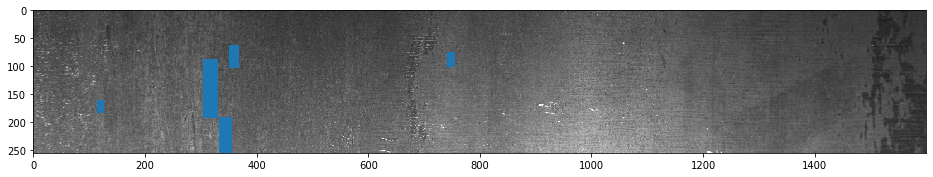

0007a71bf 3


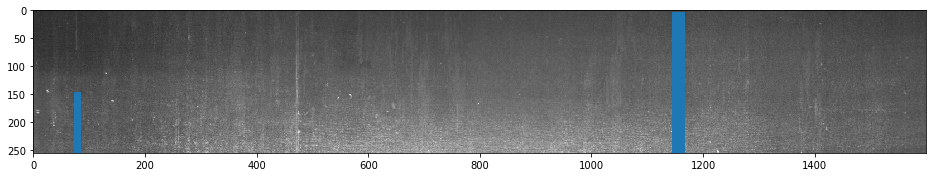

000a4bcdd 1


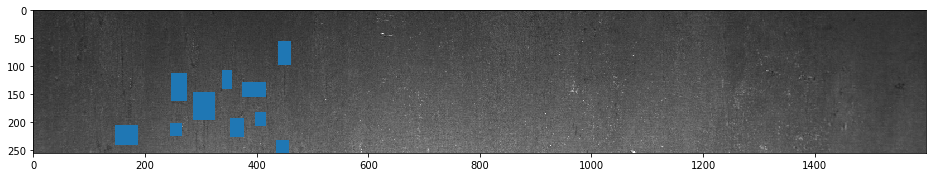

000f6bf48 4


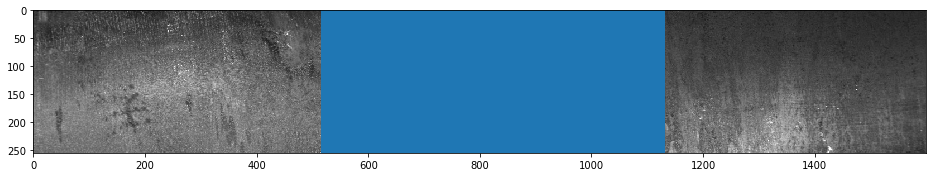

002fc4e19 1


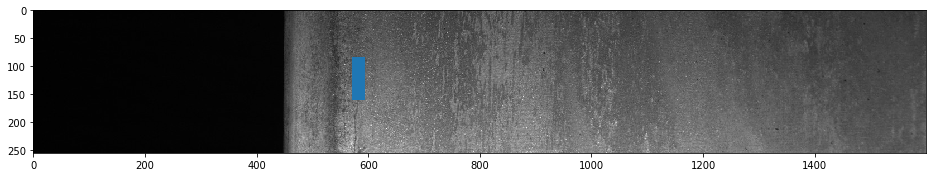

002fc4e19 2


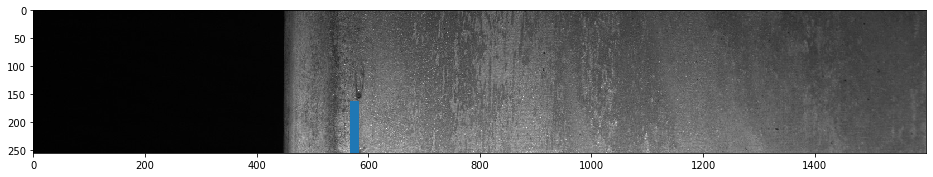

5e581254c 3


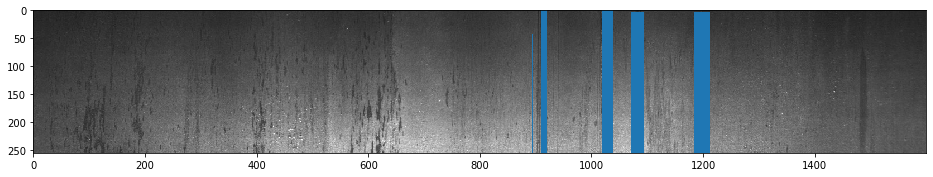

In [31]:
for t in train.itertuples():
    if pd.isna(t.EncodedPixels):
        continue
        
    if (t.ImageId_ClassId.startswith('5e581254c') or 
        t.ImageId_ClassId.startswith('002fc4e19') or
        t.ImageId_ClassId.startswith('0007a71bf') or
        t.ImageId_ClassId.startswith('000f6bf48') or
        t.ImageId_ClassId.startswith('0002cc93b') or
        t.ImageId_ClassId.startswith('000a4bcdd') or
        t.ImageId_ClassId.startswith('002fc4e19') or
        t.ImageId_ClassId.startswith('002fc4e19') or
        t.ImageId_ClassId.startswith('0002cc93b')):
    
        bbs = get_bounding_boxes(t.EncodedPixels)
        
        imageid, classid = t.ImageId_ClassId.split('.jpg_')
        
        print(imageid, classid)
        
        fig = plt.figure(figsize=(16, 3))
        im = plt.imread(f'../data/original/train_images/{imageid}.jpg').astype('float32')
        im /= 255
        
        plt.imshow(im, cmap='gray')
        ax = fig.get_axes()[0]

        for bb in bbs:
            r = Rectangle((bb.xmin, bb.ymin), bb.size()[0], bb.size()[1])
            ax.add_patch(r)
            
        plt.show()

In [43]:
xs = []
ys = []
for t in train.itertuples():
    if pd.isna(t.EncodedPixels):
        continue
        
    bbs = get_bounding_boxes(t.EncodedPixels)
    for bb in bbs:
        x, y = bb.size()
        xs.append(x)
        ys.append(y)
        
xs = np.array(xs, dtype='int16')
ys = np.array(ys, dtype='int16')

EEEEE 10940
EEEEE 3072
EEEEE 2047
EEEEE 5542
EEEEE 3052
EEEEE 4736
EEEEE 2815
EEEEE 9984
EEEEE 5168
EEEEE 4565
EEEEE 7040
EEEEE 14847
EEEEE 16127
EEEEE 4863
EEEEE 2751
EEEEE 6272
EEEEE 5314
EEEEE 2560
EEEEE 4352
EEEEE 5973
EEEEE 2816
EEEEE 25024
EEEEE 2432
EEEEE 4602
EEEEE 2688
EEEEE 4608
EEEEE 3312
EEEEE 6912
EEEEE 1023
EEEEE 3584
EEEEE 1024
EEEEE 767
EEEEE 1535
EEEEE 12736
EEEEE 1078
EEEEE 1791
EEEEE 2404
EEEEE 1197
EEEEE 1792
EEEEE 2304
EEEEE 6325
EEEEE 4096
EEEEE 1253
EEEEE 512
EEEEE 11221
EEEEE 4501
EEEEE 4064
EEEEE 2048
EEEEE 24038
EEEEE 4800
EEEEE 4160
EEEEE 5077
EEEEE 25343
EEEEE 5077
EEEEE 4816
EEEEE 6890
EEEEE 6122
EEEEE 5600
EEEEE 2773
EEEEE 1791
EEEEE 2560
EEEEE 5356
EEEEE 12742
EEEEE 768
EEEEE 5376
EEEEE 3072
EEEEE 3040
EEEEE 1792
EEEEE 2944
EEEEE 3712
EEEEE 6144
EEEEE 7423
EEEEE 15612
EEEEE 10752
EEEEE 3776
EEEEE 1407
EEEEE 2815
EEEEE 48096
EEEEE 7935
EEEEE 2406
EEEEE 28608
EEEEE 2303
EEEEE 1792
EEEEE 21502
EEEEE 9200
EEEEE 4842
EEEEE 5120
EEEEE 9200
EEEEE 1760
EEEEE 1792

KeyboardInterrupt: 

(0, 1599)

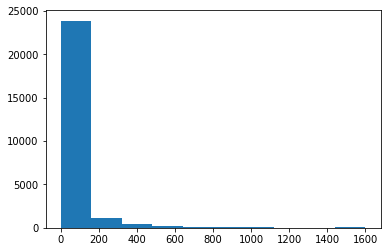

In [37]:
plt.hist(xs)
xs.min(), xs.max()

(-32256, 32624)

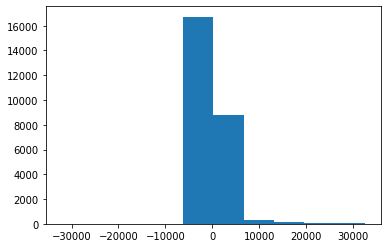

In [38]:
plt.hist(ys)
ys.min(), ys.max()